This notebook experiments with the idea of **discriminator fine-tuning**. The idea is simple - 

* First, train a GAN on the *unlabeled* version of the dataset with which you would like to conduct adversarial training as well. 
* We then construct a perturbed version of the original dataset as shown in [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/adversarial_training/01_1_adv_training_scratch.ipynb).
* We then use the pre-trained discriminator to test its generalizability to this newly created dataset. 

A pictorial depiction of these steps has been shown in the figure below - 

<br>
<center>
<img src = "https://i.ibb.co/DV6LsMC/image.png"></img>
</center>

## Initial Setup

In [ ]:
# To prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(tf.__version__)

2.3.0


## Dataset Collection and Preprocessing

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [ ]:
# Add channel dimension
train_images = np.expand_dims(train_images, -1) 
test_images = np.expand_dims(test_images, -1) 

# Our GAN was trained on images that were normalized to the
# range of [-1, 1], so we need to follow same preprocessing steps
train_images = train_images - 127.5 / 127.5
test_images = test_images - 127.5 / 127.5

## Model Building Utilities

In [ ]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

def get_training_model(main_activation='relu'):
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same", activation=main_activation)(inputs)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Conv2D(62, (3, 3), strides=2, padding="same", activation=main_activation)(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256)(x)
    outputs = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

get_training_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 62)          17918     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 62)          0         
_________________________________________________________________
flatten (Flatten)            (None, 248)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [ ]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

## Train a Regular Image Classification Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

regular_model = get_training_model()
regular_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)
).shuffle(buffer_size=4096).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)
).batch(BATCH_SIZE)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.7984 - accuracy: 0.7991 - val_loss: 0.4502 - val_accuracy: 0.8394
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3982 - accuracy: 0.8589 - val_loss: 0.4287 - val_accuracy: 0.8493
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3554 - accuracy: 0.8722 - val_loss: 0.4190 - val_accuracy: 0.8577
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3302 - accuracy: 0.8808 - val_loss: 0.3666 - val_accuracy: 0.8730
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3159 - accuracy: 0.8864 - val_loss: 0.3836 - val_accuracy: 0.8665
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2964 - accuracy: 0.8918 - val_loss: 0.3669 - val_accuracy: 0.8754
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2865 - accuracy: 0.8964 - val_loss: 0.3992 - val_accuracy: 0.8684
Epoch 

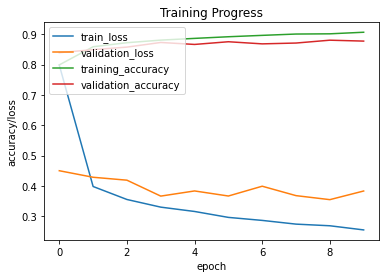

In [ ]:
history = regular_model.fit(train_dataset, 
                            validation_data=test_dataset, 
                            epochs=10)
plot_progress(history)

In [ ]:
predictions = regular_model.predict(test_images)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.79      0.82      1000
     Trouser       0.92      0.98      0.95      1000
    Pullover       0.87      0.76      0.81      1000
       Dress       0.91      0.83      0.87      1000
        Coat       0.75      0.87      0.80      1000
      Sandal       0.95      0.98      0.97      1000
       Shirt       0.67      0.71      0.69      1000
     Sneaker       0.95      0.93      0.94      1000
         Bag       0.98      0.95      0.97      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,792,13,14,23,4,3,149,0,2,0
Trouser,1,984,3,5,3,1,2,0,1,0
Pullover,13,7,762,4,136,0,78,0,0,0
Dress,21,50,8,828,49,0,40,0,4,0
Coat,1,3,36,22,868,0,69,0,1,0
Sandal,0,0,0,0,0,981,0,10,0,9
Shirt,92,9,54,28,95,0,713,1,8,0
Sneaker,0,0,0,0,0,30,0,934,0,36
Bag,9,2,3,2,4,7,15,6,950,2
Ankle boot,0,0,0,0,0,8,1,28,0,963


## Creating the  Datasets (train + eval) Adversarial Training with FGSM

In [ ]:
def get_model_preds(input_image, class_names_map, model):
        logits = model.predict(input_image)
        preds = tf.nn.softmax(logits)
        top_idx = np.argsort(-preds)[0][0]
        top_prob = -np.sort(-preds)[0][0]
        top_class = np.array(class_names_map)[top_idx]
        return top_class, top_prob


def generate_adverarial_pattern(input_image, image_label_idx, model, loss_func):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        #prediction = tf.nn.softmax(prediction)
        loss = loss_func(image_label_idx, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
# We want maximize the cross-entropy loss
scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def generate_perturbed_images(input_images, image_label_idxs, model, loss_func, eps=0.01):
  perturbed_images = []
  # don't use list on large data - used just to view fancy progress-bar
  for image, label in tqdm(list(zip(input_images, image_label_idxs))): 
      image = tf.convert_to_tensor(np.array([image]))
      adv_pattern = generate_adverarial_pattern(image, label, model, loss_func)
      clip_adv_pattern = tf.clip_by_value(adv_pattern, clip_value_min=-1, clip_value_max=1.)
      perturbed_img = image + (eps * clip_adv_pattern)
      perturbed_img = tf.clip_by_value(perturbed_img, clip_value_min=-1, clip_value_max=1.)[0]
      perturbed_images.append(perturbed_img)

  return tf.convert_to_tensor(perturbed_images)

In [ ]:
perturbed_test_imgs = generate_perturbed_images(input_images=test_images, 
                                                image_label_idxs=test_labels, model=regular_model, 
                                                loss_func=scc, eps=0.05)

100%|██████████| 10000/10000 [00:55<00:00, 178.69it/s]


## Evaluating the Current Model on the Perturbed Test Set

In [ ]:
predictions = regular_model.predict(perturbed_test_imgs)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.27      0.41      1000
     Trouser       0.04      0.01      0.01      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.46      0.38      0.41      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.20      0.81      0.32      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.24      0.96      0.38      1000
         Bag       0.04      0.01      0.02      1000
  Ankle boot       0.70      0.14      0.23      1000

    accuracy                           0.26     10000
   macro avg       0.25      0.26      0.18     10000
weighted avg       0.25      0.26      0.18     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,266,2,0,119,0,398,0,146,61,8
Trouser,1,8,0,57,0,824,0,33,76,1
Pullover,1,128,0,43,0,501,0,322,4,1
Dress,2,1,0,378,0,146,0,374,77,22
Coat,0,40,0,111,0,317,0,500,30,2
Sandal,0,0,0,0,0,805,0,194,0,1
Shirt,42,35,0,109,0,450,0,295,52,17
Sneaker,0,0,0,0,0,36,0,961,0,3
Bag,1,2,0,8,0,255,0,721,11,2
Ankle boot,0,0,0,0,0,337,0,528,0,135


We see a performance drop from 88% to 26% when we introduced perturbation. 

## Create the Final Training Dataset: Pertubed + Original

In [ ]:
perturbed_train_imgs = generate_perturbed_images(input_images=train_images, 
                                                image_label_idxs=train_labels, model=regular_model, 
                                                loss_func=scc, eps=0.05)

100%|██████████| 60000/60000 [05:35<00:00, 178.72it/s]


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)
)

adv_train_dataset = tf.data.Dataset.from_tensor_slices(
    (perturbed_train_imgs, train_labels)
)

final_dataset = adv_train_dataset.concatenate(train_dataset).shuffle(buffer_size=120000).batch(BATCH_SIZE)

## Loading the Pre-trained Weights of Discriminator

In [ ]:
# Discriminator
# Reference: https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/GANs_w_Adversaries.ipynb
def disc_network():
    disc = tf.keras.Sequential()
    inputShape = (28, 28, 1)

    disc.add(tf.keras.layers.Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    disc.add(tf.keras.layers.Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    disc.add(tf.keras.layers.Flatten())
    disc.add(tf.keras.layers.Dense(512))
    disc.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    disc.add(tf.keras.layers.Dropout(0.3))
    disc.add(tf.keras.layers.Dense(1))
    disc.add(tf.keras.layers.Activation("sigmoid"))
    
    return disc

In [ ]:
# Get the discriminator weights (model training  was done in the notebook mentioned above)
!wget -q https://www.dropbox.com/s/n32doh46k72lw8r/disc_fashionmnist.h5

In [ ]:
discriminator = disc_network()
discriminator.load_weights("disc_fashionmnist.h5")
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

## Create a Custom Model with the Pre-trained Discriminator Weights

In [ ]:
custom_model = tf.keras.Model(discriminator.input, discriminator.layers[-4].output)
custom_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [ ]:
# First, we just warm up the training keeping the pre-trained weights
# of the discriminator to non-trainable
custom_model.trainable = False
inputs = tf.keras.layers.Input((28, 28, 1))
x = custom_model(inputs, training=False)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_5 (Functional)    (None, 512)               1658240   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 1,663,370
Trainable params: 5,130
Non-trainable params: 1,658,240
_________________________________________________________________


## Training our Custom Model and Evaluation

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 10.4191 - accuracy: 0.7484 - val_loss: 13.0921 - val_accuracy: 0.8081
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 6.3651 - accuracy: 0.8007 - val_loss: 12.0708 - val_accuracy: 0.8201
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 6.0445 - accuracy: 0.8064 - val_loss: 12.3685 - val_accuracy: 0.8357
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 5.6910 - accuracy: 0.8130 - val_loss: 10.9165 - val_accuracy: 0.8524
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 5.4705 - accuracy: 0.8155 - val_loss: 14.3170 - val_accuracy: 0.8098
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 5.3029 - accuracy: 0.8202 - val_loss: 10.0819 - val_accuracy: 0.8416
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 5.5539 - accuracy: 0.8192 - val_loss: 9.5333 - val_ac

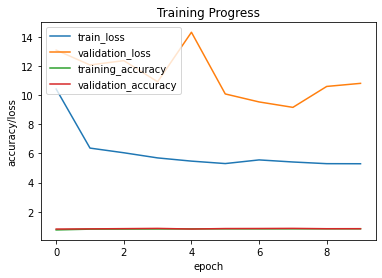

In [ ]:
# Set up an early stopping callback to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# We resume the training of our regular model
history = model.fit(final_dataset, 
                            validation_data=test_dataset, 
                            epochs=10,
                            callbacks=[es])
plot_progress(history)

In [ ]:
predictions = model.predict(perturbed_test_imgs)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.64      0.73      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.61      0.69      0.65      1000
       Dress       0.71      0.91      0.80      1000
        Coat       0.62      0.64      0.63      1000
      Sandal       0.97      0.90      0.93      1000
       Shirt       0.54      0.41      0.47      1000
     Sneaker       0.90      0.90      0.90      1000
         Bag       0.87      0.96      0.91      1000
  Ankle boot       0.90      0.96      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,638,1,20,114,3,0,199,0,25,0
Trouser,1,951,2,41,1,0,1,0,3,0
Pullover,20,4,686,13,204,0,58,0,15,0
Dress,16,6,8,914,21,0,27,0,8,0
Coat,2,3,194,81,642,0,56,0,22,0
Sandal,0,0,0,0,0,895,1,64,11,29
Shirt,80,2,203,101,151,0,412,0,48,3
Sneaker,0,0,0,0,0,12,0,904,4,80
Bag,2,2,3,15,6,8,7,1,956,0
Ankle boot,0,0,0,0,1,8,0,31,2,958


Let's see if performance can be improved with further fine-tuning. 

In [ ]:
custom_model.trainable = True
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_5 (Functional)    (None, 512)               1658240   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 1,663,370
Trainable params: 1,663,370
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 4.7519 - accuracy: 0.8127 - val_loss: 2.7032 - val_accuracy: 0.8375
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2320 - accuracy: 0.8456 - val_loss: 1.8730 - val_accuracy: 0.8491
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9010 - accuracy: 0.8531 - val_loss: 1.3753 - val_accuracy: 0.8247
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7421 - accuracy: 0.8561 - val_loss: 0.9206 - val_accuracy: 0.8563
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6476 - accuracy: 0.8581 - val_loss: 0.8823 - val_accuracy: 0.8603
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5346 - accuracy: 0.8620 - val_loss: 0.9884 - val_accuracy: 0.8398
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5492 - accuracy: 0.8604 - val_loss: 0.9556 - val_accuracy

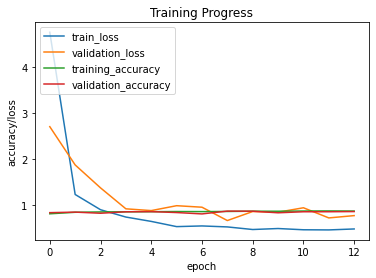

In [ ]:
# Set up an early stopping callback to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# We resume the training of our regular model
history = model.fit(final_dataset, 
                            validation_data=test_dataset, 
                            epochs=15,
                            callbacks=[es])
plot_progress(history)

Notice that the training has stabilized quite a bit after unfreezing the pre-trained weights of the discriminator. 

In [ ]:
predictions = model.predict(perturbed_test_imgs)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.71      0.90      0.79      1000
     Trouser       0.96      0.97      0.96      1000
    Pullover       0.67      0.83      0.74      1000
       Dress       0.88      0.86      0.87      1000
        Coat       0.74      0.74      0.74      1000
      Sandal       0.92      0.98      0.95      1000
       Shirt       0.76      0.37      0.49      1000
     Sneaker       0.97      0.89      0.92      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.94      0.97      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,898,2,26,23,4,0,33,0,14,0
Trouser,5,974,4,10,3,0,1,1,2,0
Pullover,17,1,828,9,108,0,29,0,8,0
Dress,51,31,17,857,24,0,16,0,4,0
Coat,1,3,188,43,736,0,26,0,3,0
Sandal,0,0,0,0,0,976,0,12,0,12
Shirt,295,6,164,29,115,1,366,0,24,0
Sneaker,0,0,0,0,0,61,0,886,0,53
Bag,0,2,5,5,3,8,9,2,966,0
Ankle boot,0,0,0,0,0,10,0,17,1,972
